In [1]:
import geopandas
import pandas
import pathlib
import numpy
import matplotlib
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
sampling_resolution = 10
threshold = 1

## Load in results
### Widths and slopes

In [34]:
width_file = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\caches\100000000\final_transects_100000000.geojson")
rec_main_channel_file = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\caches\100000000\rec_main_channel.geojson")
widths = geopandas.read_file(width_file)
main_channel = geopandas.read_file(rec_main_channel_file)

### Slopes and Flows

In [35]:
mannings_file = pathlib.Path(r"C:\Users\pearsonra\Documents\data\river_bathemetry\mannings_n\bathy.csv.gz")
mannings = pandas.read_csv(mannings_file)

### Measured cross sections

In [39]:
cross_section_file = pathlib.Path(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Waikanae/Waikanae_Cross_Sections_NIWA/2014_Survey_XS_NZTM.shp")
cross_sections = geopandas.read_file(cross_section_file)

# Translate the samples to correct reach

In [80]:
widths['nzsegment'] = numpy.zeros(len(widths['widths']), dtype=int) * -1
for i, row in main_channel.iterrows():
    widths.loc[widths.intersects(row.geometry), ('nzsegment')] = row['nzsegment']

# Add the flows and manning's n to the widths table

In [81]:
key_parameters = widths[['nzsegment', 'slope', 'widths_Savgol', 'geometry']]
key_parameters = key_parameters[key_parameters['nzsegment'] != 0]

In [82]:
key_parameters['mannings_n'] = numpy.zeros(len(key_parameters['nzsegment']), dtype=int)
key_parameters['flow'] = numpy.zeros(len(key_parameters['nzsegment']), dtype=int)
for nzsegment in key_parameters['nzsegment'].unique():
    key_parameters.loc[key_parameters['nzsegment'] == nzsegment, ('mannings_n')] = mannings[mannings['nzsegment'] == nzsegment]['n'].unique()[0]
    key_parameters.loc[key_parameters['nzsegment'] == nzsegment, ('flow')] = mannings[mannings['nzsegment'] == nzsegment]['flow'].unique()[0]

Note a section is out of order, which is why the flow goes down.

<AxesSubplot:>

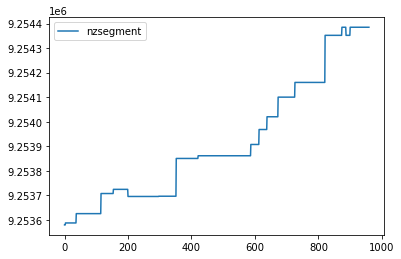

In [83]:
key_parameters[['nzsegment']].plot()

## Calculate depth

In [84]:
key_parameters['depth_Neal_et_al'] = (key_parameters['mannings_n'] * key_parameters['flow'] / (numpy.sqrt(key_parameters['slope']) * key_parameters['widths_Savgol'])) ** (3/5)

In [85]:
a = 0.745
b = 0.305
K_0 = 6.16

In [86]:
key_parameters['depth_Smart_et_al'] = (key_parameters['flow'] / (K_0 * key_parameters['widths_Savgol'] * key_parameters['slope'] ** b)) ** (1 / (1+a))

## Plot results
Include plots of each parameter - Manning's n, flow, depth and slope - used to calculate depth

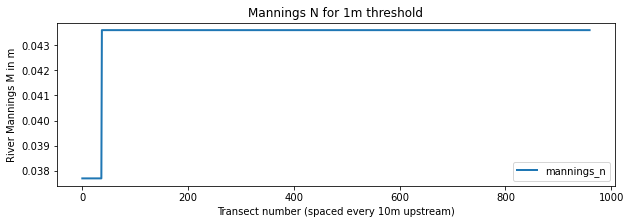

In [87]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['mannings_n']].plot(ax=ax, linewidth=2)
ax.set(title=f"Mannings N for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River Mannings M in m");

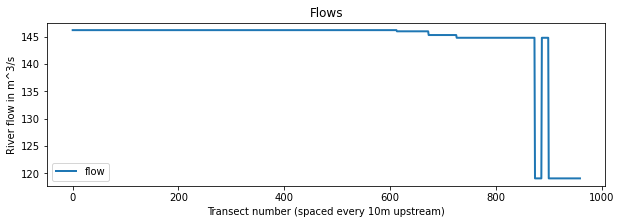

In [88]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['flow']].plot(ax=ax, linewidth=2)
ax.set(title=f"Flows")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River flow in m^3/s");

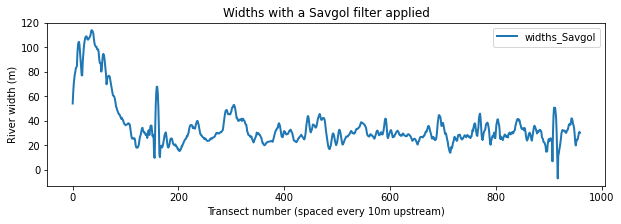

In [89]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['widths_Savgol']].plot(ax=ax, linewidth=2)
ax.set(title=f"Widths with a Savgol filter applied")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width (m)");

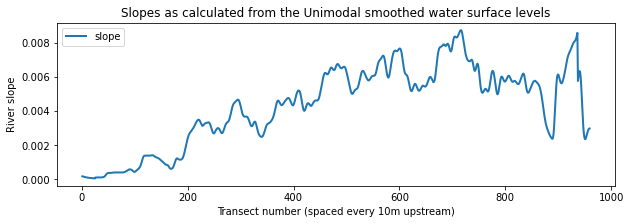

In [90]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['slope']].plot(ax=ax, linewidth=2)
ax.set(title=f"Slopes as calculated from the Unimodal smoothed water surface levels")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River slope");

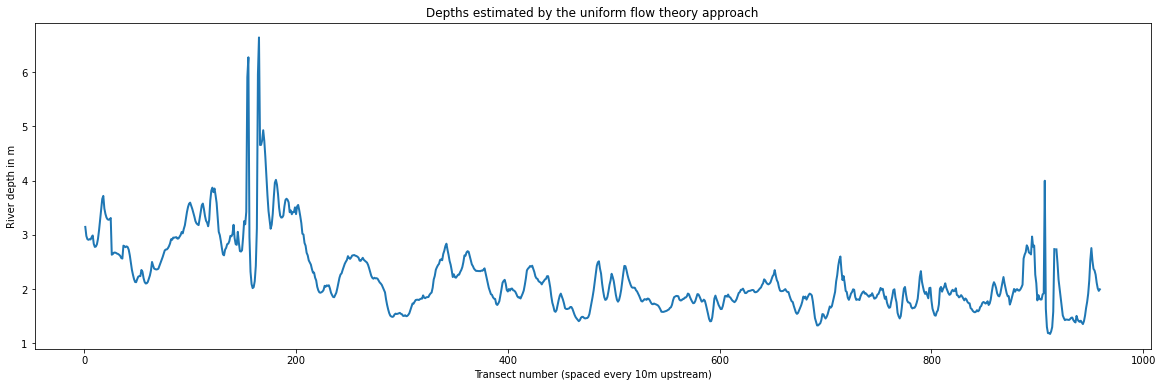

In [91]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
key_parameters['depth_Neal_et_al'].plot(ax=ax, linewidth=2)
ax.set(title=f"Depths estimated by the uniform flow theory approach")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");

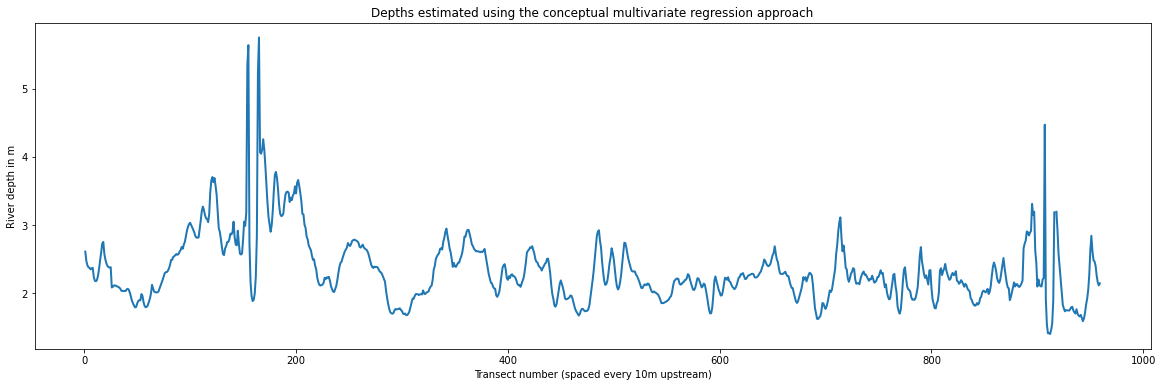

In [92]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
key_parameters['depth_Smart_et_al'].plot(ax=ax, linewidth=2)
ax.set(title="Depths estimated using the conceptual multivariate regression approach")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");

## Measured cross sections

Plot minimum height (i.e height of the bed)

<AxesSubplot:xlabel='Section'>

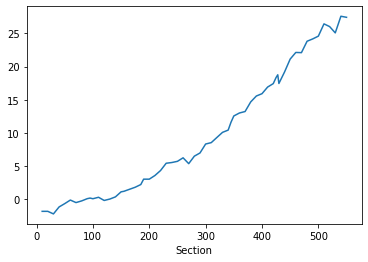

In [93]:
cross_sections.groupby('Section')['Level'].min().plot()

Pull out the centre point for each section

In [94]:
section_centres = {'Section': [], 'geometry': []}
for section in cross_sections['Section'].unique():
    section_centre = cross_sections[cross_sections['Section'] == section].iloc[round(len(cross_sections[cross_sections['Section'] == section])/2)]
    section_centres['Section'].append(section_centre['Section'])
    section_centres['geometry'].append(section_centre['geometry'])

In [97]:
section_centres = geopandas.GeoDataFrame(section_centres).head(2)

Cycle through each section identifying the nearest section in the key parameters

In [96]:
key_parameters.head()

,nzsegment,slope,widths_Savgol,geometry,mannings_n,flow,depth_Neal_et_al,depth_Smart_et_al
0,9253579,NaN,54.062937,"LINESTRING (1769104.572 5473348.540, 1769104.0...",0.0377,146.193834,NaN,NaN
1,9253579,0.000167,63.251748,"LINESTRING (1769104.410 5473349.266, 1769114.2...",0.0377,146.193834,3.145241,2.608849
2,9253579,0.000164,69.902098,"LINESTRING (1769096.587 5473349.952, 1769124.1...",0.0377,146.193834,2.976770,2.470675
3,9253587,0.000154,74.546620,"LINESTRING (1769095.331 5473349.991, 1769133.9...",0.0377,146.193834,2.918003,2.407279
4,9253587,0.000143,77.717949,"LINESTRING (1769100.644 5473348.321, 1769143.5...",0.0377,146.193834,2.907636,2.380028


In [ ]:
for index, row in section_centres.iterrows():
    row.

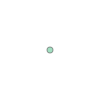

In [99]:
section_centres.dist

In [100]:
import shapely.ops
shapely.ops.nearest_points(key_parameters.iloc[0].geometry, section_centres.iloc[0].geometry)

(<shapely.geometry.point.Point at 0x1ddd5e71760>,
 <shapely.geometry.point.Point at 0x1ddd5e713a0>)

<AxesSubplot:>

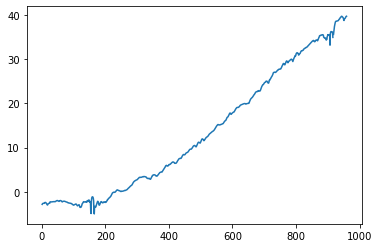

In [57]:
(widths['min_z_unimodal']-key_parameters['depth_Smart_et_al']).plot()